In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dropout, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Activation, Flatten, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
import time

In [2]:
# using unverfied ssl
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
# load train and test data
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

X = np.concatenate((X_train,X_test))
y = np.concatenate((Y_train,Y_test))



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10000, random_state=1234)
X_valid, X_test, y_valid, y_test = train_test_split(X_test,y_test, test_size=0.5)

print('X_train, y_train :', X_train.shape, y_train.shape)
print('X_valid, y_valid:', X_valid.shape, y_valid.shape)
print('X_test, y_test:', X_valid.shape, y_valid.shape)

170508288/170498071 [==============================] - 2s 0us/step
X_train, y_train : (50000, 32, 32, 3) (50000, 1)
X_valid, y_valid: (5000, 32, 32, 3) (5000, 1)
X_test, y_test: (5000, 32, 32, 3) (5000, 1)


In [4]:
# Encoding the class values to 10 value binary vector
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_valid = to_categorical(y_valid)

# Converting the train values to float 
X_train_norm = X_train.astype('float32')
X_valid_norm = X_valid.astype('float32')
X_test_norm = X_test.astype('float32')
# normalize the images with mean 0 and standard deviation of 1
X_train_norm = X_train_norm / 255.0
X_valid_norm = X_valid_norm / 255.0
X_test_norm = X_test_norm / 255.0

In [5]:
def plot_learning_curves(history):
    # plot loss
    plt.subplot(211)
    plt.title('Minibatch Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='green', label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='green', label='validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    

# Variant 3 - Adding dropout layers in cnn layers

In [6]:
def train_vgg_model_dropout():
    
    model = Sequential()
    
    #conv block 1
    model.add(Conv2D(64, (3, 3), activation='relu',   padding='same', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu',   padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    
    #conv block 2
    model.add(Conv2D(128, (3, 3), activation='relu',   padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu',   padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    
    #conv block 3
    model.add(Conv2D(256, (3, 3), activation='relu',   padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), activation='relu',  padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    
    #Fully connected layers
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(10, activation='softmax'))
    
    
    
    # compile model
    #opt = SGD(lr=0.001, momentum=0.9)
    opt = Adam(lr=0.001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    print(model.summary())

    
    return model

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       7

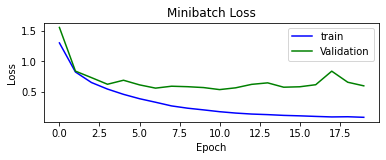

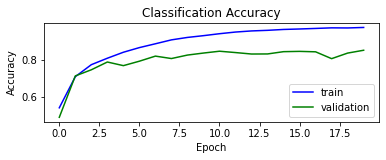

In [7]:
start_time = time.time()

train_model = train_vgg_model_dropout()
history = train_model.fit(X_train_norm, y_train , epochs=20, batch_size=100 , validation_data=(X_valid_norm, y_valid), verbose=0)

elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')

# evaluate model
scores = train_model.evaluate(X_test_norm, y_test, verbose=0)
print('\nTest result: %.3f and loss: %.3f'  % (scores[1]*100,scores[0]))


print('Traing loss', history.history['loss'],'validation Loss', history.history['val_loss'])
print('Traing accuracy', history.history['accuracy'], 'validation Accuracy', history.history['val_accuracy'])

# learning curves
plot_learning_curves(history)

# Added dropout only in dense layers

In [10]:
def train_vgg_model_spatial_dropout():
    
    model = Sequential()
    
    #conv block 1
    model.add(Conv2D(64, (3, 3), activation='relu',   padding='same', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu',   padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    
    
    #conv block 2
    model.add(Conv2D(128, (3, 3), activation='relu',   padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu',   padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    
    
    #conv block 3
    model.add(Conv2D(256, (3, 3), activation='relu',   padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), activation='relu',  padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    
    
    #Fully connected layers
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(10, activation='softmax'))
    
    print(model.summary())
    
    # compile model
    #opt = SGD(lr=0.001, momentum=0.9)
    opt = Adam(lr=0.001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_9 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
batch_normalization_10 (Batc (None, 16, 16, 128)      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Total Training Time: 9.40 min

Test result: 82.140 loss: 0.853
Traing loss [1.2812433242797852, 0.733973503112793, 0.5529574155807495, 0.4101422131061554, 0.3101174533367157, 0.23201413452625275, 0.15702389180660248, 0.12262233346700668, 0.1135876402258873, 0.0896085724234581, 0.07361353933811188, 0.06703046709299088, 0.07176250219345093, 0.05828969180583954, 0.047987982630729675, 0.05484902486205101, 0.052024099975824356, 0.04738646373152733, 0.03794527053833008, 0.0429748110473156] validation Loss [1.6024490594863892, 0.9480694532394409, 0.6757946014404297, 0.7672619819641113, 0.6085184812545776, 0.5918418765068054, 0.725410521030426, 0.7552763819694519, 0.8171269297599792, 0.7362881302833557, 0.7404516339302063, 0.8118593692779541, 0.9090242385864258, 0.7769098281860352, 0.8596264719963074, 0.9093481302261353, 0.8018739819526672, 0.9249060750007629, 0.8106024265289307, 0.8821814656257629]
Traing accuracy [0.5646399855613708, 0.7441400289535522, 0.8093000054359436, 0.8571799993515015

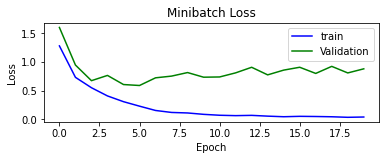

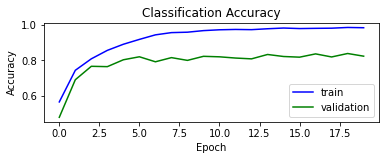

In [11]:
start_time = time.time()

train_model = train_vgg_model_spatial_dropout()
history = train_model.fit(X_train_norm, y_train , epochs=20, batch_size=100 , validation_data=(X_valid_norm, y_valid), verbose=0)



elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')

# evaluate model
scores = train_model.evaluate(X_test_norm, y_test, verbose=0)
print('\nTest result: %.3f loss: %.3f'  % (scores[1]*100,scores[0]))


print('Traing loss', history.history['loss'],'validation Loss', history.history['val_loss'])
print('Traing accuracy', history.history['accuracy'], 'validation Accuracy', history.history['val_accuracy'])

# learning curves
plot_learning_curves(history)